In [1]:
import os
import json
import requests
from pathlib import Path

from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Import Mask RCNN
from detector.mrcnn import visualize
import detector.mrcnn.model as modellib

import lego

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.5.1'

In [2]:
import os
from PIL import Image, ImageDraw, ImageFont

def render_detections(image, boxes, masks, class_ids, scores, class_names, image_name=None, filter_classs_names=None,
               scores_thresh=0.1, save_dir=None, mode=0):
    """
        image: image array
        image_name: image name
        boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
        masks: [num_instances, height, width]
        class_ids: [num_instances]
        scores: confidence scores for each box
        class_names: list of class names of the dataset
        filter_classs_names: (optional) list of class names we want to draw
        scores_thresh: (optional) threshold of confidence scores
        save_dir: (optional) the path to store image
        mode: (optional) select the result which you want
                mode = 0 , save image with bbox,class_name,score and mask;
                mode = 1 , save image with bbox,class_name and score;
                mode = 2 , save image with class_name,score and mask;
                mode = 3 , save mask with black background;
    """
    mode_list = [0, 1, 2, 3]
    assert mode in mode_list, "mode's value should in mode_list %s" % str(mode_list)

    if save_dir is None and image_name is not None:
        save_dir = os.path.join(os.getcwd(), "output")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    useful_mask_indices = []

    N = boxes.shape[0]
    if not N:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    for i in range(N):
        # filter
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        if score is None or score < scores_thresh:
            continue

        label = class_names[class_id]
        if (filter_classs_names is not None) and (label not in filter_classs_names):
            continue

        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue

        useful_mask_indices.append(i)

    if len(useful_mask_indices) == 0:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return

    colors = visualize.random_colors(len(useful_mask_indices))

    if mode != 3:
        masked_image = image.astype(np.uint8).copy()
    else:
        masked_image = np.zeros(image.shape).astype(np.uint8)

    if mode != 1:
        for index, value in enumerate(useful_mask_indices):
            masked_image = visualize.apply_mask(masked_image, masks[:, :, value], colors[index])

    masked_image = Image.fromarray(masked_image)

    if mode == 3:
        if image_name is not None:
            masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
        return masked_image

    draw = ImageDraw.Draw(masked_image)
    colors = np.array(colors).astype(int) * 255

    for index, value in enumerate(useful_mask_indices):
        class_id = class_ids[value]
        score = scores[value]
        label = class_names[class_id]

        y1, x1, y2, x2 = boxes[value]
        if mode != 2:
            color = tuple(colors[index])
            draw.rectangle((x1, y1, x2, y2), outline=color)

        # Label
        # font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 15)
        # draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255), font)
        draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255))

    if image_name is not None:
        masked_image.save(os.path.join(save_dir, '%s.jpg' % (image_name)))
    return masked_image

In [3]:
REPO_URL = 'https://api.github.com/repos/LilDataMonster/Lego-CNN/releases/latest'
response = json.loads(requests.get(REPO_URL).text)

In [4]:
LEGO_WEIGHTS_URL = response['assets'][0]['browser_download_url']
LEGO_WEIGHTS_NAME = os.path.basename(LEGO_WEIGHTS_URL)

LEGO_WEIGHTS_PATH = Path(os.path.join('weights', LEGO_WEIGHTS_NAME))

weights_response = requests.get(LEGO_WEIGHTS_URL, stream=True)
total_size_in_bytes= int(weights_response.headers.get('content-length', 0))
progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
if not LEGO_WEIGHTS_PATH.exists():
    # Streaming, so we can iterate over the response.
    block_size = 1024 #1 Kibibyte
    with open(LEGO_WEIGHTS_NAME, 'wb') as file:
        for data in weights_response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR downloading pretrained weights")
progress_bar.close()

  0%|          | 0.00/262M [00:00<?, ?iB/s]


In [5]:
class InferenceConfig(lego.LegoConfig().__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

In [6]:
model = modellib.MaskRCNN(mode="inference", model_dir="", config=config)
print("Loading weights ", LEGO_WEIGHTS_PATH)
model.load_weights(LEGO_WEIGHTS_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
Loading weights  mask_rcnn_lego_0200.h5


In [7]:
# dataset = lego.LegoDataset()
# dataset.prepare()
#dataset.class_names
class_names = ['BG', '2431', '3003', '3005', '3010', '3020', '3021', '3022', '3023', '3024', '3069', '3070', '3176', '3622', '3700', '3710', '3958', '4150', '4274', '6141', '11211', '11476', '11477', '15068', '15573', '22885', '24201', '24246', '25269', '29119', '29120', '33909', '35480', '36840', '47458', '47905', '85984', '87079', '87087', '87580', '93273', '98138', '99206']

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


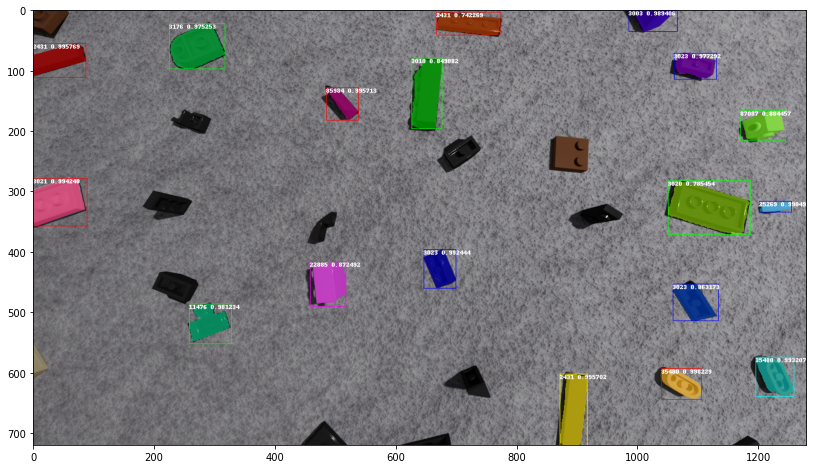

In [8]:
image_path = '000000.jpg'
image = tf.keras.preprocessing.image.load_img(image_path)
frame = tf.keras.preprocessing.image.img_to_array(image)
results = model.detect([frame], verbose=0)[0]

output_image = render_detections(frame, results['rois'], results['masks'], results['class_ids'], results['scores'], class_names, filter_classs_names=None, scores_thresh=0.1, save_dir=None, mode=0)

plt.figure(figsize=(16,8))
plt.imshow(output_image)